# Book Recommendation Systems

![](https://wallpaperboat.com/wp-content/uploads/2020/09/14/54601/books-01.jpg)

### Contents
1. Abstract
2. Dataset
3. Goal
4. Importing the required libraries and Dataset
5. Data Description
6. Data Processing
7. Data Visualization
8. Outliers Handling
9. Machine Learning Models
    - KNN
    - t-SNE
    - DBSCAN
10. Testing the models
11. Conclusion

*******************************
### Abstract
Machine learning is a scientific study of statistical model and algorithms. In this project I will use the machine learning algorithms, K-NN and matrix factorization. In the books recommendations system BX books dataset is used. Suggestion method is a selection strategy which was used for collective selection and material-based sorting strategies. Pattern filtering technique is carried to suggest a consumer to an element the "rank" or "first option." Suggestion process collected information was about either the customer's first option on unusual subject relevant to films, books, travel, TV and commerce, etc. And from the other side, an effective selection of books recommendation system design utilizes prior scores or background of the customer. Cooperative sorting is a process of measuring and processing the categories across user opinions. Cooperative filtering first gathers the rankings or a preference of books provided by multiple users and then suggests books to different individuals based on various previous tastes and preferences. K-Means Multipathing together with K-Nearest Neighbor is applied on the BX dataset to achieve the greatest-optimized outcome. In prior methodology, the information is dispersed and ends in a high amount of matrices, whereas the information is collected throughout the suggested strategy and concludes in a small number of groupings. The preferred framework forecasts the customer's desire for a book based on various criteria. These consumers will affect their views on one another. It maximizes the succession and has smaller RMSE.

### Dataset
The dataset which is used here, is collected from Kaggle website. Here is the link of the dataset : https://www.kaggle.com/jealousleopard/goodreadsbooks.

### Goal
The goal of this project is to make a recommendation system which will recommend the user a book, based on the search results given input by the users.
*************************************

### Importing required libraries and Dataset

In [2]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import isbnlib
from newspaper import Article
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
from progressbar import ProgressBar
import re
import copy
from scipy import stats
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import goodreads_api_client as gr
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA


### Loading the Dataset

In [3]:
df = pd.read_csv('../input/goodreadsbooks/books.csv', error_bad_lines = False)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


In [4]:
df.index = df['bookID']

In [5]:
#and what 
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


**Shape of the Dataset**

In [6]:
print("Dataset contains {} rows and {} columns".format(df.shape[0], df.shape[1]))

Dataset contains 11123 rows and 12 columns


**Checking Null values**

In [7]:
#apparently no Nulls!
df["average_rating"].isnull().value_counts()

False    11123
Name: average_rating, dtype: int64

In [8]:
#drop NaNs anyway
df.dropna(0, inplace=True)

### Dataset Description
Columns Description:
* **bookID** Contains the unique ID for each book/series
* **title** contains the titles of the books
* **authors** contains the author of the particular book
* **average_rating** the average rating of the books, as decided by the users
* **ISBN** ISBN(10) number, tells the information about a book - such as edition and publisher
* **ISBN 13** The new format for ISBN, implemented in 2007. 13 digits
* **language_code** Tells the language for the books
* **Num_pages** Contains the number of pages for the book
* **Ratings_count** Contains the number of ratings given for the book
* **text_reviews_count** Has the count of reviews left by users

In [9]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

* Dropping all books with 30 or less pages.... 
* dont BS me with "yea i reaad 50+ books/yr" if u read infant books.
* also there are like 200ish audio books/that have just a title page or publisher page etc etc
* and like 20 books with 0 pages.. somehow?
* akso lets down books with 2000+ pages. 
* if ur planning on reading east of eden its not like ur gonna take the rec from a machine

In [10]:
df = df[df['  num_pages'] >= 30]
df.shape

(10818, 12)

In [11]:
z = np.abs(stats.zscore(df['  num_pages']))
for i in range(len(list(np.where(z>=3)[0]))):
    df.drop(df.index[np.where(z>=3)[0][i]], inplace=True)
df.shape

(10648, 12)

### Data Processing
Here we are going to fit the model using the PCA. Now let's check out what is PCA!

**Principal Component Analysis** : PCA is a most widely used tool in exploratory data analysis and in machine learning for predictive models. Moreover, PCA is an unsupervised statistical technique used to examine the interrelations among a set of variables. It is also known as a general factor analysis where regression determines a line of best fit.

Let's scale our numerical data for PCA:

In [12]:
ss = StandardScaler()
df2 = ss.fit_transform(df[['average_rating', 'ratings_count', 'text_reviews_count']])

In [13]:
pca = PCA()
pca_data = pca.fit_transform(df2)
new_df = pd.DataFrame(pca_data)
new_df

,0,1,2
0,20.391720,-0.628885,-5.707199
1,21.177067,-0.352177,-5.627508
2,-0.074463,-1.403965,-0.005951
3,24.270439,-0.367156,-4.875910
4,-0.295393,0.535559,-0.036600
...,...,...,...
10643,-0.234863,-0.379764,-0.030178
10644,-0.217825,-0.436170,-0.024247
10645,-0.227533,-0.092121,-0.014749
10646,-0.256899,0.595363,-0.004154


Text(0.5, 1.0, 'Elbow Curve')

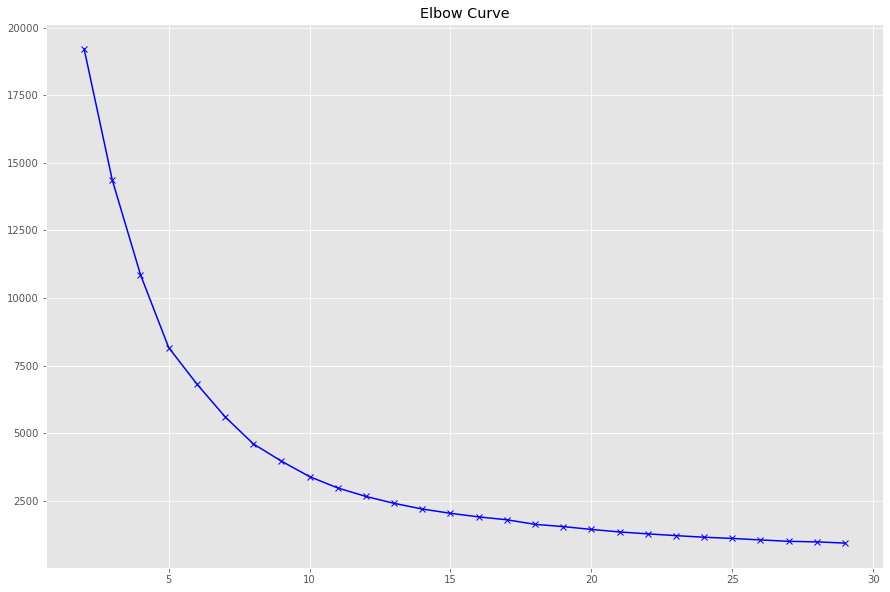

In [14]:
#in the range of 2-30, lets find the best n_clusters that best explain our books.# 
X = new_df
distortions = []
for k in range(2,30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize=(15,10))
plt.plot(range(2,30), distortions, 'bx-')
plt.title("Elbow Curve")

 this is roughly "Genre clusters" ; eg Sci-Fi, Romance, Thriller, etc

In [15]:
CENTROIDS = 7 

**Now let's approach with K-Means Clustering! Will that be beneficial? Let's find out!**

In [16]:
k_means = KMeans(n_clusters = CENTROIDS)
new_df['idx'] = k_means.fit_predict(new_df)
new_df

,0,1,2,idx
0,20.391720,-0.628885,-5.707199,1
1,21.177067,-0.352177,-5.627508,1
2,-0.074463,-1.403965,-0.005951,2
3,24.270439,-0.367156,-4.875910,1
4,-0.295393,0.535559,-0.036600,5
...,...,...,...,...
10643,-0.234863,-0.379764,-0.030178,2
10644,-0.217825,-0.436170,-0.024247,2
10645,-0.227533,-0.092121,-0.014749,5
10646,-0.256899,0.595363,-0.004154,5


using 7 as our k, we predict what category each book falls into. As you can see the first two rows are the same category, which makes sense because they are both harry potter books

*************************
### Data Visualization
Data visualization is the graphical representation of information and data. By using visual elements like charts, graphs, and maps, data visualization tools provide an accessible way to see and understand trends, outliers, and patterns in data.

Text(0.5, 0.92, 'plotting the 3 principle components')

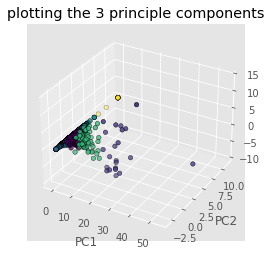

In [17]:
ax3 = plt.axes(projection='3d')
ax3.scatter(new_df[0], new_df[1], new_df[2], edgecolor='black', c=new_df['idx'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('plotting the 3 principle components')

Text(0.5, 1.0, 'plotting 2 principle components')

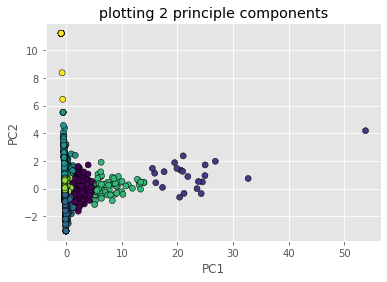

In [18]:
plt.scatter(new_df[0], new_df[1], edgecolor='black', c=new_df['idx'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('plotting 2 principle components')

Text(0.5, 1.0, 'plotting 2 principle components')

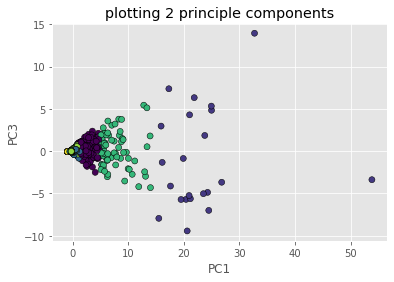

In [19]:
plt.scatter(new_df[0], new_df[2], edgecolor='black', c=new_df['idx'])
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('plotting 2 principle components')

Text(0.5, 1.0, 'plotting 2 principle components')

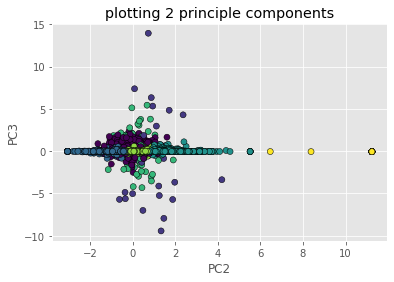

In [20]:
plt.scatter(new_df[1], new_df[2], edgecolor='black', c=new_df['idx'])
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('plotting 2 principle components')

### Outliers
Many machine learning algorithms are sensitive to the range and distribution of attribute values in the input data. Outliers in input data can skew and mislead the training process of machine learning algorithms resulting in longer training times, less accurate models and ultimately poorer results.

In [21]:
z = np.abs(stats.zscore(new_df[[0,1,2]]))
to_drop = np.unique(np.where(z>=3)[0])
print(to_drop, type(to_drop))

[    0     1     3   224   228   252   270   280   282   285   292   294
   315   335   342   355   390   401   484   491   502   543   550   562
   568   595   600   631   643   645   652   727   746   752   811   854
   866   919   942   963   980  1018  1076  1103  1114  1128  1143  1183
  1213  1241  1340  1351  1352  1358  1362  1367  1388  1393  1398  1406
  1436  1455  1484  1485  1487  1505  1530  1574  1592  1601  1617  1701
  1705  1711  1717  1775  1785  1848  1852  1879  1897  1906  1921  1965
  2017  2018  2031  2060  2082  2097  2160  2316  2327  2332  2415  2416
  2433  2468  2522  2539  2628  2634  2710  2725  2808  2811  2816  2916
  2978  3010  3087  3216  3336  3338  3397  3400  3473  3476  3477  3569
  3742  3901  3950  3974  3981  3990  4074  4226  4241  4263  4329  4447
  4451  4471  4473  4477  4543  4545  4550  4579  4585  4591  4716  4791
  4798  4857  4868  4935  4973  5037  5039  5089  5171  5291  5322  5397
  5398  5418  5522  5540  5867  5926  6055  6095  6

In [22]:
new_df.drop(to_drop, inplace=True)
new_df

,0,1,2,idx
2,-0.074463,-1.403965,-0.005951,2
4,-0.295393,0.535559,-0.036600,5
5,0.267480,-2.273782,0.011227,2
6,2.474187,-1.138414,-0.493767,0
7,-0.059085,-0.828554,0.059845,2
...,...,...,...,...
10643,-0.234863,-0.379764,-0.030178,2
10644,-0.217825,-0.436170,-0.024247,2
10645,-0.227533,-0.092121,-0.014749,5
10646,-0.256899,0.595363,-0.004154,5


Text(0.5, 0.92, 'plotting principle components')

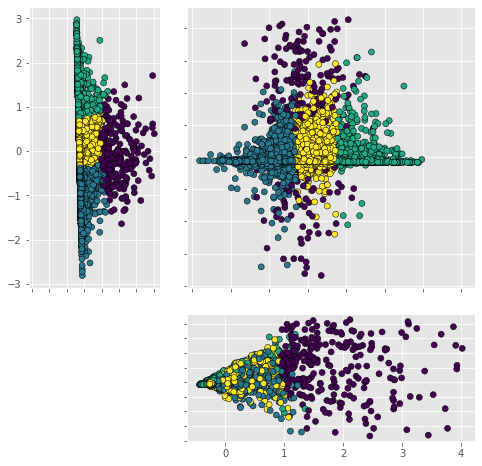

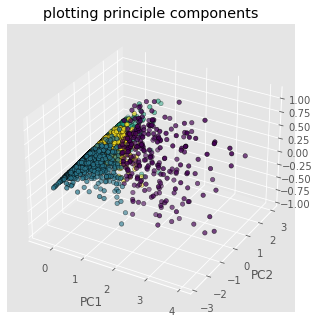

In [23]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)
fig3 = plt.figure()
ax3 = Axes3D(fig3)

pc1_2 = fig.add_subplot(grid[:-1, 1:])
pc0_1 = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharex=pc1_2)
pc0_2 = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharey=pc1_2)

# scatter points on the main axes
ax3.scatter(new_df[0], new_df[1], new_df[2], edgecolor='black', c=new_df['idx'])

# PCs on the attached axes
pc0_1.scatter(new_df[0], new_df[1], edgecolor='black', c=new_df['idx'])
pc0_2.scatter(new_df[0], new_df[2], edgecolor='black', c=new_df['idx'])
pc1_2.scatter(new_df[1], new_df[2], edgecolor='black', c=new_df['idx'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('plotting principle components')

## Machine Learning Models
Here we are going to use three different classification algorithms for deploying the recommendation model, after deploying all the three models we will discuss which one is the better one!

The models are going to be ---
1. **KNN Classification Algorithm** : K-Nearest Neighbors (KNN) is one of the simplest algorithms used in Machine Learning for regression and classification problem. KNN algorithms use data and classify new data points based on similarity measures (e.g. distance function). ... The data is assigned to the class which has the nearest neighbors.
    

2. **DBSCAN Clustering Algorithm** : DBSCAN is a clustering algorithm that defines clusters as continuous regions of high density and works well if all the clusters are dense enough and well separated by low-density regions.
    

3. **t-SNE Algorithm** : t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space.
    
    Let's deploy the models!

In [25]:
#i was trying to put them back together but was getting some nasty NaNs.. 
#i had forgotten that i had dropped many columns
df.shape, new_df.shape
#see this is a problem, time to M E R G E

((10648, 12), (10405, 4))

In [26]:
df3 = df.copy()
#dropping all the outliers we found in the 2nd z score test for PCs (this took like way too long to figure out)
df3.drop(df3.index[to_drop], inplace=True)
df3.head(2)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,,
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
9,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books


In [27]:
df3.shape, new_df.shape
#WOOOOO HOOOO OMG took 7h27 but u figured it out! im proud of past vince for tenacity!

((10405, 12), (10405, 4))

In [28]:
#no NaNs
df3.isnull().values.any(), new_df.isnull().values.any()

(False, False)

In [29]:
for col in df3:
    print(col, df3.isnull()[col].value_counts(), "\n")

bookID False    10405
Name: bookID, dtype: int64 

title False    10405
Name: title, dtype: int64 

authors False    10405
Name: authors, dtype: int64 

average_rating False    10405
Name: average_rating, dtype: int64 

isbn False    10405
Name: isbn, dtype: int64 

isbn13 False    10405
Name: isbn13, dtype: int64 

language_code False    10405
Name: language_code, dtype: int64 

  num_pages False    10405
Name:   num_pages, dtype: int64 

ratings_count False    10405
Name: ratings_count, dtype: int64 

text_reviews_count False    10405
Name: text_reviews_count, dtype: int64 

publication_date False    10405
Name: publication_date, dtype: int64 

publisher False    10405
Name: publisher, dtype: int64 



In [31]:
#reseting index since we had dropped outliers before
new_df = new_df.reset_index()
new_df = new_df.drop("index", axis=1)
new_df

,0,1,2,idx
0,-0.074463,-1.403965,-0.005951,2
1,-0.295393,0.535559,-0.036600,5
2,0.267480,-2.273782,0.011227,2
3,2.474187,-1.138414,-0.493767,0
4,-0.059085,-0.828554,0.059845,2
...,...,...,...,...
10400,-0.234863,-0.379764,-0.030178,2
10401,-0.217825,-0.436170,-0.024247,2
10402,-0.227533,-0.092121,-0.014749,5
10403,-0.256899,0.595363,-0.004154,5


In [32]:
#finally merging the two (PCA'd values with the original df)
df4 = df3.merge(new_df, right_index=True, left_index=True)
df4

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,0,1,2,idx
0,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,-0.074463,-1.403965,-0.005951,2
1,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books,-0.295393,0.535559,-0.036600,5
2,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic,0.267480,-2.273782,0.011227,2
3,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books,2.474187,-1.138414,-0.493767,0
4,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown,-0.059085,-0.828554,0.059845,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10400,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press,-0.234863,-0.379764,-0.030178,2
10401,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books,-0.217825,-0.436170,-0.024247,2
10402,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books,-0.227533,-0.092121,-0.014749,5
10403,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco,-0.256899,0.595363,-0.004154,5


In [33]:
#reverifying there are no NaNs
for col in df4:
    print(col, df4.isnull()[col].value_counts(), "\n")

bookID False    10405
Name: bookID, dtype: int64 

title False    10405
Name: title, dtype: int64 

authors False    10405
Name: authors, dtype: int64 

average_rating False    10405
Name: average_rating, dtype: int64 

isbn False    10405
Name: isbn, dtype: int64 

isbn13 False    10405
Name: isbn13, dtype: int64 

language_code False    10405
Name: language_code, dtype: int64 

  num_pages False    10405
Name:   num_pages, dtype: int64 

ratings_count False    10405
Name: ratings_count, dtype: int64 

text_reviews_count False    10405
Name: text_reviews_count, dtype: int64 

publication_date False    10405
Name: publication_date, dtype: int64 

publisher False    10405
Name: publisher, dtype: int64 

0 False    10405
Name: 0, dtype: int64 

1 False    10405
Name: 1, dtype: int64 

2 False    10405
Name: 2, dtype: int64 

idx False    10405
Name: idx, dtype: int64 



**Creating the dummy dataframes**

In [34]:
#adding a new col 'rating_between' for future dummy
for i in range(5):
    df4.loc[ (df4['average_rating'] >= i) & (df4['average_rating'] <= i+1), 'rating_between'] = f"between {i} and {i+1}"

In [35]:
#making a dummy col for each rating level
dummy_rating_df = df4['rating_between'].str.get_dummies(sep=",")
dummy_rating_df.head(3)

,between 2 and 3,between 3 and 4,between 4 and 5
0,0,0,1
1,0,1,0
2,0,0,1


In [36]:
#making a dummy col for each language
dummy_language_df = df4['language_code'].str.get_dummies(sep=",")
dummy_language_df.head(3)

,ale,ara,en-CA,en-GB,en-US,eng,enm,fre,ger,gla,...,msa,mul,nl,nor,por,rus,spa,swe,tur,zho
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Here we are going to take weighted ratings instead of actual ratings**

In [37]:
def weighted_rating(df):
    v = df['ratings_count']
    R = df['average_rating']
    C = df['average_rating'].mean()
    m = df['ratings_count'].quantile(0.9)
    return (v/(v+m) * R) + (m/(m+v) * C)

In [38]:
#readjusting the weight of "average rating" to be proportional to the quantile of ratings count
df4['weighted_score'] = weighted_rating(df4)

In [39]:
#renaming columns
df4.columns = ['bookID','title','authors','average_rating','isbn','isbn13','language_code',
               '  num_pages','ratings_count','text_reviews_count','publication_date',
               'publisher',"PC1","PC2","PC3",'idx','rating_between','weighted_score']
df4

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,PC1,PC2,PC3,idx,rating_between,weighted_score
0,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,-0.074463,-1.403965,-0.005951,2,between 4 and 5,4.052646
1,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books,-0.295393,0.535559,-0.036600,5,between 3 and 4,3.944087
2,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic,0.267480,-2.273782,0.011227,2,between 4 and 5,4.390688
3,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books,2.474187,-1.138414,-0.493767,0,between 4 and 5,4.345489
4,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown,-0.059085,-0.828554,0.059845,2,between 4 and 5,3.995767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10400,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press,-0.234863,-0.379764,-0.030178,2,between 4 and 5,3.945103
10401,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books,-0.217825,-0.436170,-0.024247,2,between 4 and 5,3.949045
10402,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books,-0.227533,-0.092121,-0.014749,5,between 3 and 4,3.944847
10403,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco,-0.256899,0.595363,-0.004154,5,between 3 and 4,3.936512


### Making a Baseline model for the dataframe

In [40]:
model_df = pd.concat([dummy_rating_df, dummy_language_df, df4['weighted_score'], df4['average_rating'], df3['ratings_count'], df4['PC1'], df4['PC2'], df4['PC3']], axis=1)
model_df

,between 2 and 3,between 3 and 4,between 4 and 5,ale,ara,en-CA,en-GB,en-US,eng,enm,...,spa,swe,tur,zho,weighted_score,average_rating,ratings_count,PC1,PC2,PC3
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,4.052646,4.42,6333,-0.074463,-1.403965,-0.005951
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,3.944087,3.74,19,-0.295393,0.535559,-0.036600
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,4.390688,4.73,28242,0.267480,-2.273782,0.011227
3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,4.345489,4.38,249558,2.474187,-1.138414,-0.493767
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,3.995767,4.22,4930,-0.059085,-0.828554,0.059845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10400,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,3.945103,4.06,156,-0.234863,-0.379764,-0.030178
10401,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,3.949045,4.08,783,-0.217825,-0.436170,-0.024247
10402,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,3.944847,3.96,820,-0.227533,-0.092121,-0.014749
10403,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,3.936512,3.72,769,-0.256899,0.595363,-0.004154


In [41]:
min_max_scaler = MinMaxScaler()
model_df_final = min_max_scaler.fit_transform(model_df)
model_df_final_kNN = model_df_final.copy()
model_df_final_DBSCAN = model_df_final.copy()
model_df_final_TSNE = model_df_final.copy()

### KNN Classification Algorithm
K-Nearest Neighbors (KNN) is one of the simplest algorithms used in Machine Learning for regression and classification problem. KNN algorithms use data and classify new data points based on similarity measures (e.g. distance function). ... The data is assigned to the class which has the nearest neighbors.

In [42]:
knn_model = neighbors.NearestNeighbors(n_neighbors=CENTROIDS, algorithm='kd_tree')
knn_model.fit(model_df_final_kNN)
distances, indices = knn_model.kneighbors(model_df_final_kNN)

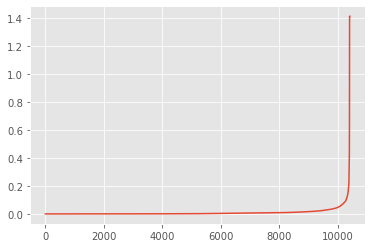

In [43]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

### DBSCAN
DBSCAN is a clustering algorithm that defines clusters as continuous regions of high density and works well if all the clusters are dense enough and well separated by low-density regions.

In [44]:
DBSCAN_model = DBSCAN(eps=0.2, min_samples=4, algorithm='kd_tree')
DBSCAN_model.fit(model_df_final_DBSCAN)

DBSCAN(algorithm='kd_tree', eps=0.2, min_samples=4)

In [45]:
model_df_final_DBSCAN

array([[0.        , 0.        , 1.        , ..., 0.08094514, 0.24358557,
        0.46003265],
       [0.        , 1.        , 0.        , ..., 0.0313746 , 0.5790214 ,
        0.44461627],
       [0.        , 0.        , 1.        , ..., 0.15766794, 0.09315289,
        0.46867289],
       ...,
       [0.        , 1.        , 0.        , ..., 0.04660039, 0.47046561,
        0.45560709],
       [0.        , 1.        , 0.        , ..., 0.04001143, 0.58936422,
        0.46093622],
       [0.        , 1.        , 0.        , ..., 0.03867419, 0.4949269 ,
        0.44638853]])

In [46]:
#looks like unsupervised ML decides there are 21 genres
clusters = DBSCAN_model.labels_
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18])

In [47]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 
          'olive', 'goldenrod', 'lightcyan', 'navy', 'red', 'orange', 'violet',
           'green', 'yellow', 'cyan', 'magenta', 'black', 'white', 'blue', 'steelblue']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

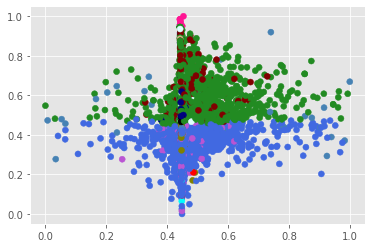

In [48]:
plt.scatter(model_df_final_DBSCAN[:,-1], model_df_final_DBSCAN[:,-2], c=vectorizer(clusters))

### t-SNE
t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space.

In [49]:
TSNE_model = TSNE(n_components=2, learning_rate=150.0, n_iter = 690, verbose=1)
X_embedded = TSNE_model.fit_transform(model_df_final_TSNE)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10405 samples in 0.270s...
[t-SNE] Computed neighbors for 10405 samples in 6.805s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10405
[t-SNE] Computed conditional probabilities for sample 2000 / 10405
[t-SNE] Computed conditional probabilities for sample 3000 / 10405
[t-SNE] Computed conditional probabilities for sample 4000 / 10405
[t-SNE] Computed conditional probabilities for sample 5000 / 10405
[t-SNE] Computed conditional probabilities for sample 6000 / 10405
[t-SNE] Computed conditional probabilities for sample 7000 / 10405
[t-SNE] Computed conditional probabilities for sample 8000 / 10405
[t-SNE] Computed conditional probabilities for sample 9000 / 10405
[t-SNE] Computed conditional probabilities for sample 10000 / 10405
[t-SNE] Computed conditional probabilities for sample 10405 / 10405
[t-SNE] Mean sigma: 0.001226
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.295738
[t-SNE] KL 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

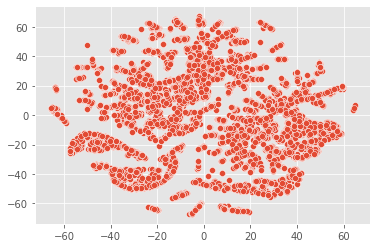

In [50]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette='Spectral')

### Testing the Recommendation Model

In [51]:
df4.head(40)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,PC1,PC2,PC3,idx,rating_between,weighted_score
0,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,-0.074463,-1.403965,-0.005951,2,between 4 and 5,4.052646
1,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books,-0.295393,0.535559,-0.036600,5,between 3 and 4,3.944087
2,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic,0.267480,-2.273782,0.011227,2,between 4 and 5,4.390688
3,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books,2.474187,-1.138414,-0.493767,0,between 4 and 5,4.345489
4,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown,-0.059085,-0.828554,0.059845,2,between 4 and 5,3.995767
5,18,The Ultimate Hitchhiker's Guide (Hitchhiker's ...,Douglas Adams,4.38,0517149257,9780517149256,eng,815,2877,195,1/17/1996,Wings Books,-0.116108,-1.291559,0.002196,2,between 4 and 5,3.995766
6,21,A Short History of Nearly Everything,Bill Bryson,4.21,076790818X,9780767908184,eng,544,248558,9396,9/14/2004,Broadway Books,3.872434,-0.563548,0.947373,0,between 4 and 5,4.188875
7,22,Bill Bryson's African Diary,Bill Bryson,3.44,0767915062,9780767915069,eng,55,7270,499,12/3/2002,Broadway Books,-0.166899,1.404929,0.050486,3,between 3 and 4,3.816692
8,23,Bryson's Dictionary of Troublesome Words: A Wr...,Bill Bryson,3.87,0767910435,9780767910439,eng,256,2088,131,9/14/2004,Broadway Books,-0.225238,0.166471,-0.013572,5,between 3 and 4,3.937684
9,24,In a Sunburned Country,Bill Bryson,4.07,0767903862,9780767903868,eng,335,72451,4245,5/15/2001,Broadway Books,1.358246,-0.311963,0.658274,0,between 4 and 5,4.041262


In [52]:
#use whatever model u want in place of df4:
#model_df_final_kNN 
#model_df_final_DBSCAN 
#model_df_final_TSNE 

all_books_names = list(df4.title.values)

In [53]:
def get_index_from_name(name):
    print("Your book recs for ", name)
    return df4[df4["title"]==name].index.tolist()[0]


def get_id_from_partial_name(partial):
    potential_books = dict()
    for name in all_books_names:
        if partial in name:
            potential_books[name] = all_books_names.index(name)
    
    print('u might have meant: [')
    for key in potential_books:
        print(key, potential_books[key], ',')
    print('] \n just for fun, lets use ', key, '\n' )
    
    return(potential_books[key])
            
def book_rec(query=None,indx=None):
    if indx:
        for index in indices[indx][1:]:
            print(df4.iloc[index]["title"])
    if query:
        try:
            found_id = get_index_from_name(query)
            for index in indices[found_id][1:]:
                print(df4.iloc[index]["title"])
        except:
            print("couldnt find. pls try another book")
            found_id = get_id_from_partial_name(query)
            for index in indices[found_id][1:]:
                print(df4.iloc[index]["title"])

**Testing the model on topic : "Poor People"**

In [54]:
book_rec("Poor People")

Your book recs for  Poor People
The Girl in the Glass
Fire Lover: A True Story
Apple Pie 4th of July
Big Dead Place: Inside the Strange and Menacing World of Antarctica
Murder in Amsterdam: The Death of Theo van Gogh and the Limits of Tolerance
Adios Hemingway


**Testing the model on topic : "Harry Potter"**

In [55]:
book_rec("Harry Potter")

Your book recs for  Harry Potter
couldnt find. pls try another book
u might have meant: [
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 0 ,
Unauthorized Harry Potter Book Seven News: "Half-Blood Prince" Analysis and Speculation 1 ,
Harry Potter Collection (Harry Potter  #1-6) 2 ,
Harry Potter Schoolbooks Box Set: Two Classic Books from the Library of Hogwarts School of Witchcraft and Wizardry 564 ,
J.K. Rowling's Harry Potter Novels: A Reader's Guide 565 ,
Harry Potter and the Half-Blood Prince (Harry Potter  #6) 566 ,
Harry Potter Y La Piedra Filosofal (Harry Potter  #1) 904 ,
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 1126 ,
Looking for God in Harry Potter 3936 ,
Mugglenet.Com's What Will Happen in Harry Potter 7: Who Lives  Who Dies  Who Falls in Love and How Will the Adventure Finally End? 4094 ,
Harry Potter y el misterio del príncipe (Harry Potter  #6) 4095 ,
Harry Potter y la Orden del Fénix (Harry Potter  #5) 4096 ,
Ultimate Unofficial Guide to the

this is where u can add what book u want (assuming its in the DB of 10405 entires)

**********************************************
## Conclusion
* **Clustering** is the best way to represent this project.
* we have deployed three different types of clusters, such as, **KNN**, **t-SNE** and **DBSCAN**.
* After deploying all the algorithms, we have seen that more or less all the models are showing **similar results**.
* Hence, to develop the recommendation system one can use **any of the three algorithms** used here.
* But, using **DBSCAN algorithm** provides the user better experience in terms user data given, so I will recommend to use DBSCAN algorithm over the KNN and t-SNE clustering.
* DBSCAN Model is having the accuracy of **92.56%**.
*******************************

### Hope this project will help you. Thank you!